In [1]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import numpy as np
import pickle

In [2]:
sequence_length = 25 # timestep

### Read Data

In [3]:
path_save = "F:/Master Project/Dataset/Extract_Data/25 joints"
f_x = open(path_save+"/test_x.pickle",'rb')
f_y = open(path_save+"/test_y.pickle",'rb')
origin_test_x = pickle.load(f_x)
origin_test_y = np.array(pickle.load(f_y))

### Sampling Function

In [4]:
def sampling_x(x):
    
    frames = x
    
    random_sample_range = 3

    # Randomly choose sample interval and start frame
    sample_interval = np.random.randint(1, random_sample_range + 1)

    start_i = np.random.randint(0, len(frames) - sample_interval * sequence_length + 1)

    # Extract frames as tensors
    image_sequence = []
#     for i in range(start_i, len(frames), sample_interval):
    end_i = sample_interval * sequence_length + start_i
    for i in range(start_i, end_i, sample_interval):
        # image_path = frames[i]
        if len(image_sequence) < sequence_length:
            image_sequence.append(frames[i])
        else:
            break
    image_sequence = np.array(image_sequence)   
    return image_sequence


def reform_to_sequence(data_x, data_y, is_training):
    
    if is_training:
        random_time = 20000
        output_x = np.zeros((len(data_x)*random_time, sequence_length, data_x[0].shape[-1]) ) #(len,timestep, 28)
        
    else:        
        random_time = 10000
        output_x = np.zeros((len(data_x)*random_time, sequence_length, data_x[0].shape[-1]) ) #(len*random_time,timestep, 28)
    
    count = 0
    output_y = np.arange( len(data_y)*random_time ) # create array
    for n_time in range(random_time):
        for i,x in enumerate(data_x):
            sequence = sampling_x(x)
            output_x[count] = sequence
            output_y[count] = data_y[i]
            count += 1
#     import pdb; pdb.set_trace()
    return output_x, output_y     

### Prepare Test Set

In [ ]:
type([origin_test_x[4] ])

In [6]:
# index = np.array([0,1,2,3,5])
# origin_test_x2 = origin_test_x[index]
# origin_test_y2 = origin_test_y[index]
index = 3

In [14]:
# test_x, test_y  = reform_to_sequence( [origin_test_x[index] ] , [origin_test_y[index]], is_training=False)
test_x, test_y  = reform_to_sequence( origin_test_x  , origin_test_y, is_training=False)

In [8]:
def create_model(num_frame, num_joint, num_output):
    model = Sequential()
    model.add(CuDNNLSTM(50, input_shape=(num_frame, num_joint),return_sequences=False))
    model.add(Dropout(0.4))#使用Dropout函数可以使模型有更多的机会学习到多种独立的表征
    model.add(Dense(60) )
    model.add(Dropout(0.4))
    model.add(Dense(num_output, activation='softmax'))
    return model

In [9]:
weights_path = '../../pretrain_model/weight-sampling-01-0.90.hdf5' # 15 frame
max_frame = 25
num_joint = 25
model = create_model(max_frame, num_joint*3, 4)
model.load_weights(weights_path)

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


### Accuracy

In [15]:
loss, acc = model.evaluate(test_x, y = test_y, batch_size=384, verbose=1)

60000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Confusion Matrix

In [16]:
y_pred=model.predict_classes(test_x)

In [21]:
cm

array([[19239,   106,    86,   569],
       [   85, 19069,   187,   659],
       [   70,  3978,  5670,   282],
       [  108,     0,     4,  9888]], dtype=int64)

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
normalize = True

cm = confusion_matrix(test_y, y_pred)
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

print(cm)

Normalized confusion matrix
[[9.6195e-01 5.3000e-03 4.3000e-03 2.8450e-02]
 [4.2500e-03 9.5345e-01 9.3500e-03 3.2950e-02]
 [7.0000e-03 3.9780e-01 5.6700e-01 2.8200e-02]
 [1.0800e-02 0.0000e+00 4.0000e-04 9.8880e-01]]


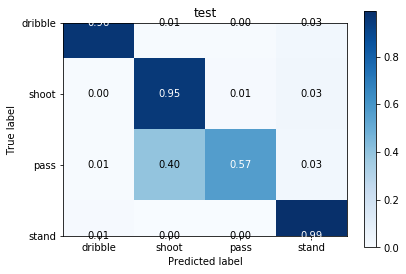

In [43]:
# classes = ['拍球','投球','传球','站立']
classes = ['dribble','shoot','pass','stand']
title = 'test'
cmap=plt.cm.Blues
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
# ax.figure.set_size_inches(10, 10)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')



# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [51]:
# import seaborn as sn
# array = [[33,2,0,0,0,0,0,0,0,1,3], 
#         [3,31,0,0,0,0,0,0,0,0,0], 
#         [0,4,41,0,0,0,0,0,0,0,1], 
#         [0,1,0,30,0,6,0,0,0,0,1], 
#         [0,0,0,0,38,10,0,0,0,0,0], 
#         [0,0,0,3,1,39,0,0,0,0,4], 
#         [0,2,2,0,4,1,31,0,0,0,2],
#         [0,1,0,0,0,0,0,36,0,2,0], 
#         [0,0,0,0,0,0,1,5,37,5,1], 
#         [3,0,0,0,0,0,0,0,0,39,0], 
#         [0,0,0,0,0,0,0,0,0,0,38]]
# df_cm = pd.DataFrame(array, index = [i for i in "ABCDEFGHIJK"],
#                   columns = [i for i in "ABCDEFGHIJK"])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True)

In [50]:
df_cm

,A,B,C,D,E,F,G,H,I,J,K
A,33,2,0,0,0,0,0,0,0,1,3
B,3,31,0,0,0,0,0,0,0,0,0
C,0,4,41,0,0,0,0,0,0,0,1
D,0,1,0,30,0,6,0,0,0,0,1
E,0,0,0,0,38,10,0,0,0,0,0
F,0,0,0,3,1,39,0,0,0,0,4
G,0,2,2,0,4,1,31,0,0,0,2
H,0,1,0,0,0,0,0,36,0,2,0
I,0,0,0,0,0,0,1,5,37,5,1
J,3,0,0,0,0,0,0,0,0,39,0
